## Monte Carlo integration

Monte Carlo is the simplest of all collocation methods.
It consist of the following steps:

1. Generate (pseudo-)random samples $Q_1, ..., Q_N$.
2. Evaluate model solver $U_1=u(Q_1), ..., U_N=u(Q_N)$ for each sample.
3. Use empirical metrics to assess statistics on the evaluations.

This was the approached introduced in [problem
formulation](./problem_formulation.ipynb), and we shall go through it again,
but in a bit more details, and leveraging some of the features introduced in
the section [generating samples](./generating_samples.ipynb).

### Generating samples

The samples that shall be used in Monte Carlo must be assumed to behave as if
drawn from the probability distribution of the model parameters on want to
model. In the case of [problem formulation](./problem_formulation.ipynb), the
samples drawn was random. Here we shall replace the random samples with
variance reduced samples from the following three schemes:

* Sobol
* Antithetic variates
* Halton

We start by generating samples from the distribution of interest:

In [1]:
from ipynb.fs.full.problem_formulation import joint

joint

J(Normal(mu=1.5, sigma=0.2), Uniform(lower=0.1, upper=0.2))

Then we generate samples from the three schemes:

In [2]:
sobol_samples = joint.sample(10000, rule="sobol")
antithetic_samples = joint.sample(10000, antithetic=True, seed=1234)
halton_samples = joint.sample(10000, rule="halton")

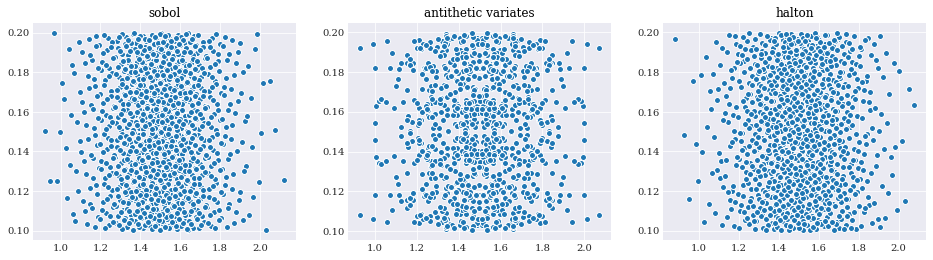

In [3]:
from matplotlib import pyplot

pyplot.rc("figure", figsize=[16, 4])

pyplot.subplot(131)
pyplot.scatter(*sobol_samples[:, :1000])
pyplot.title("sobol")

pyplot.subplot(132)
pyplot.scatter(*antithetic_samples[:, :1000])
pyplot.title("antithetic variates")

pyplot.subplot(133)
pyplot.scatter(*halton_samples[:, :1000])
pyplot.title("halton")


pyplot.show()

From the three plots above it is easy to see both how the Sobol sequence have
more structure, and the antithetic variate have observable symmetries.

### Evaluating model solver

Like in the case of [problem formulation](./problem_formulation.ipynb) again,
evaluation is straight forward:

In [4]:
from ipynb.fs.full.problem_formulation import model_solver, coordinates
import numpy

sobol_evals = numpy.array([
    model_solver(sample) for sample in sobol_samples.T])

antithetic_evals = numpy.array([
    model_solver(sample) for sample in antithetic_samples.T])

halton_evals = numpy.array([
    model_solver(sample) for sample in halton_samples.T])

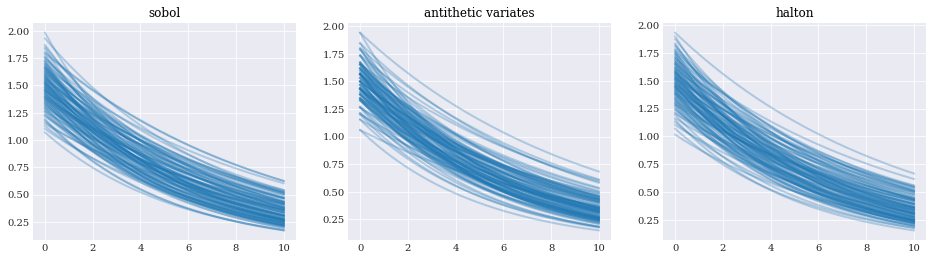

In [5]:
pyplot.subplot(131)
pyplot.plot(coordinates, sobol_evals[:100].T, alpha=0.3)
pyplot.title("sobol")

pyplot.subplot(132)
pyplot.plot(coordinates, antithetic_evals[:100].T, alpha=0.3)
pyplot.title("antithetic variates")

pyplot.subplot(133)
pyplot.plot(coordinates, halton_evals[:100].T, alpha=0.3)
pyplot.title("halton")

pyplot.show()

### Error analysis

Having a good estimate on the statistical properties allows us to asses the
properties of the uncertainty in the model. However, it does not allow us to
assess the accuracy of the methods used. To do that we need to compare the
statistical metrics with their analytical counterparts. To do so, we use the
reference analytical solution and error function as defined in  [problem
formulation](./problem_formulation.ipynb).

In [6]:
from ipynb.fs.full.problem_formulation import error_in_mean, indices, eps_mean

eps_sobol_mean = [error_in_mean(
    numpy.mean(sobol_evals[:idx], 0)) for idx in indices]

eps_antithetic_mean = [error_in_mean(
    numpy.mean(antithetic_evals[:idx], 0)) for idx in indices]

eps_halton_mean = [error_in_mean(
    numpy.mean(halton_evals[:idx], 0)) for idx in indices]

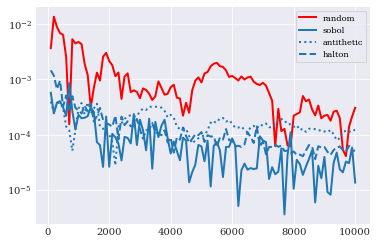

In [7]:
pyplot.rc("figure", figsize=[6, 4])

pyplot.semilogy(indices, eps_mean, "r", label="random")
pyplot.semilogy(indices, eps_sobol_mean, "-", label="sobol")
pyplot.semilogy(indices, eps_antithetic_mean, ":", label="antithetic")
pyplot.semilogy(indices, eps_halton_mean, "--", label="halton")

pyplot.legend()
pyplot.show()

Here we see that for our little problem, all new schemes outperforms
classical random samples with Sobol on top, followed by Halton and antithetic
variate.

For the error in variance estimation we have:

In [8]:
from ipynb.fs.full.problem_formulation import error_in_variance, eps_variance

eps_halton_variance = [error_in_variance(
    numpy.var(halton_evals[:idx], 0)) for idx in indices]

eps_sobol_variance = [error_in_variance(
    numpy.var(sobol_evals[:idx], 0)) for idx in indices]

eps_antithetic_variance = [error_in_variance(
    numpy.var(antithetic_evals[:idx], 0)) for idx in indices]

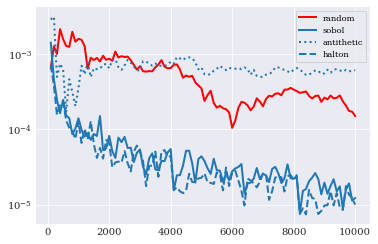

In [9]:
pyplot.semilogy(indices, eps_variance, "r", label="random")
pyplot.semilogy(indices, eps_sobol_variance, "-", label="sobol")
pyplot.semilogy(indices, eps_antithetic_variance, ":", label="antithetic")
pyplot.semilogy(indices, eps_halton_variance, "--", label="halton")

pyplot.legend()
pyplot.show()

In this case Sobol and Halton er quite comparable as the best performers.
Antithetic variate seems to now work out, with performance lower than
classical random samples.

Note that the conclusion here is not that antithetic variate don't work, but
rather that it is perhaps not the right tool for this job.